<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/4b_curva_roc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de documentos

Definimos la función para calcular el radio de falsos positivos.


In [0]:
def radio_falsos_positivos(probabilities, thres):
  return np.mean(probabilities >= thres)

Definimos la función para calcular el radio de verdaderos positivos.


In [0]:
def radio_verdaderos_positivos(probabilities, thres):
  return np.mean(probabilities >= thres)

Función que calcula la curva ROC

In [0]:
def roc(probabilities, y):
    positivos = np.where(y == 1)
    negativos = np.where(y == 0)

    rvps = np.zeros(np.unique(probabilities).shape[0])
    rfps = np.zeros(np.unique(probabilities).shape[0])
    
    for i, p in enumerate(np.unique(probabilities)[::-1]):
        rvps[i] = radio_verdaderos_positivos(probabilities[positivos], p)
        rfps[i] = radio_falsos_positivos(probabilities[negativos], p)

    return rvps, rfps

Definimos funciones para calcular el área bajo la curva ROC usando la [fórmula de Shoelace](https://en.wikipedia.org/wiki/Shoelace_formula)

In [0]:
def area_poligono(vertices):
    area = 0.0
    n_vert = len(vertices)
    for i in range(n_vert - 1):
        area = area + vertices[i][0] * vertices[i + 1][1]
        area = area - vertices[i + 1][0] * vertices[i][1]

    area = area + vertices[n_vert - 1][0] * vertices[0][1]
    area = area - vertices[0][0] * vertices[n_vert - 1][1]

    return 0.5 * abs(area)

def aucroc(tfp, tvp):
  auc = 0.0
  fprev = 0.0
  vprev = 0.0
  for i,(f,v) in enumerate(zip(tfp, tvp)):
    auc += area_poligono([[fprev, 0], [fprev, vprev], [f, v], [f, 0]])
    fprev = f
    vprev = v

  return auc + area_poligono([[fprev, 0], [fprev, vprev], [1, 1], [1, 0]])

Descargamos los subconjuntos de entrenamiento y validación del conjunto de documentos _20 Newsgroups_.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc']
remove = ('headers', 'footers', 'quotes')
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

Calculamos la representación de bolsa de palabras para cada subconjunto.

In [0]:
tfidf = TfidfVectorizer(sublinear_tf = True, max_df = 0.5,
                        stop_words = 'english')
X_ent = tfidf.fit_transform(data_train.data)
y_ent = data_train['target']

X_val = tfidf.transform(data_test.data)
y_val = data_test['target']

Instancia un clasificador de regresión logística entrenado mediante descenso por gradiente

In [7]:
m = SGDClassifier(loss = 'log')
m.fit(X_ent, y_ent)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Obtenemos las predicciones (probabilidades) de los ejemplos del subconjunto de validación.

In [0]:
prob = m.predict_proba(X_val)[:,1]

Calculamos los radios de verdaderos positivos y de falsos positivos para cada umbral.

In [0]:
rvps, rfps = roc(prob, y_val)

Graficamos la curva ROC

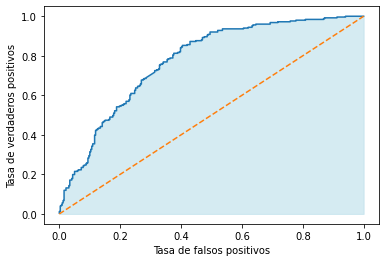

In [10]:
plt.plot(rfps, rvps)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(rfps, rvps, 0, alpha=0.5, color = 'lightblue')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.show()

Calculamos su area bajo la curva

In [11]:
aucroc(rfps, rvps)

0.7748004845820495

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, prob)

0.7748004845820479